# Generate Log for Maintenance Activitiy of WROMY LightSensors

Use the light sensors of WROMY to identify maintenance slots and plot them as calendar plots 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import calplot

import july
from july.utils import date_range


from pathlib import Path

In [26]:
config = {}

config['threshold'] = 10 ## light threshold to classify as <light on> / <light off>

config['output'] = "/import/freenas-ffb-01-data/wromy_files/maintenance_lx_sensors.csv"

config['start_date'] = '01/01/2022' ## MM/DD/YYYY
config['end_date']   = '08/15/2022' ## MM/DD/YYYY

In [27]:
def __update_maintenance_protocoll(config):

    ## make new output file with header
    with open(config['output'], mode="w") as f:
        f.write("Sensor,Timestamp,Date,Time,State\n")
    
    ## iterate for dates
    for date in pd.date_range(start=config['start_date'], end=config['end_date']):

        fdate = str(date)[:10].replace("-","")

        ## interate for all sensors of WROMY
        for sensor in [1,4,5,6,7,8,9]:

            filename = f'WS{sensor}_{fdate}.txt'
            datapath = f'/import/freenas-ffb-01-data/romy_archive/{date.year}/BW/WROMY/LX{sensor}.D/'

            ## read file
            if Path(datapath+filename).exists():
                df = pd.read_csv(datapath+filename, names=['Date', 'Time', 'State'])
            else:
                print(f" -> {datapath+filename} does not exists!")
                continue
                
            ## smooth the light sensor data
            df['smoothed'] = df['State'].rolling(10, center=True).mean()

            ## apply threshold
            df['smoothed'] = df['smoothed'].where(df.smoothed > config['threshold']).fillna(0)
            df['smoothed'] = df['smoothed'].clip(lower=None, upper=config['threshold'])

            ## calculate differences for picking
            df['State'] = df.smoothed.diff()/config['threshold']

            ## get start and end points of light period
            select = df.where(abs(df.State) > 0).dropna()

            ## modify data
            select.drop(columns=["smoothed"], inplace=True)
            select = select.astype(int)
        #     select.Time = select.Time.astype(int)
            select['State'] = select['State'].replace(-1, 0)
        
            ## format and write to output file
            with open(config['output'], mode="a") as f:
                for idx, row in select.iterrows():
                    dd = str(row.Date)
                    tt = str(row.Time).zfill(6)
                    ts = f"{dd[:4]}-{dd[4:6]}-{dd[6:8]}T{tt[:2]}:{tt[2:4]}:{tt[4:6]}"
                    f.write(f"WS{sensor},{ts},{row.Date},{row.Time},{row.State}\n");

In [28]:
__update_maintenance_protocoll(config)

 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX1.D/WS1_20220101.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX4.D/WS4_20220101.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX5.D/WS5_20220101.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX6.D/WS6_20220101.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX7.D/WS7_20220101.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX9.D/WS9_20220101.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX1.D/WS1_20220102.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX4.D/WS4_20220102.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX5.D/WS5_20220102.txt does not exists!
 -> /import/freenas-ffb-01-data/romy_archive/2022/BW/WROMY/LX6.D/WS6_20220102.txt does not exists!
 -> /impor

### Make Calendar Plots

In [29]:
## load the maintenance file
df = pd.read_csv(config['output'])

## convert to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'].replace("T"," "))

## reset the index
df.set_index('Timestamp', inplace = True)

## group by dates and sum the states
df_compressed = df.groupby(['Date','Sensor'])['State'].sum().reset_index()
df_compressed['sensor_count'] = np.ones(len(df_compressed))
df_compressed = df_compressed.groupby(['Date'])['sensor_count'].sum().reset_index()
df_compressed['Date'] = pd.to_datetime(df_compressed['Date'].astype(str), format="%Y%m%d")
df_compressed.set_index('Date', inplace = True)


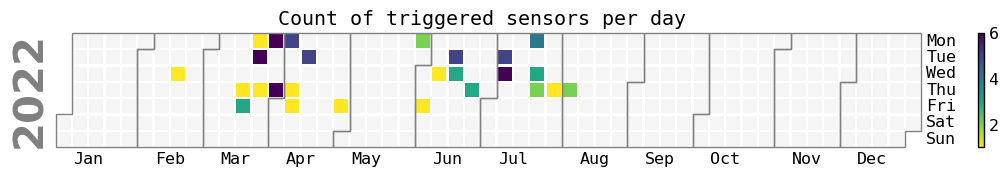

In [30]:
#cmap = plt.get_cmap('RdBu',7)

pl1 = calplot.calplot(data = df_compressed['sensor_count'],
                      how = 'sum', 
                      cmap = 'viridis_r', 
                      colorbar = True,
#                       figsize = (16, 4), 
                      suptitle = "Count of triggered sensors per day")


In [31]:
# pl1 = calplot.calplot(data = df['State'],
#                       how = 'sum', 
#                       cmap = 'viridis_r', 
#                       colorbar = True,
# #                       figsize = (16, 4), 
#                       suptitle = "Total Acivities per Day")

In [40]:

dates = date_range("2022-01-01", "2022-12-31")

maintenance = pd.DataFrame()

maintenance['dates'] = dates

states = np.zeros(len(dates)) 
for n, date in enumerate(maintenance['dates']):
    if str(date).replace("-","") in df['Date']:
        states[n] = df['Date','sensor_count']
        
maintenance['states'] = states

july.calendar_plot(dates, 
                   maintenance['states'],
                   cmap = 'Greens');

KeyError: ('Date', 'sensor_count')

In [62]:
df_compressed

,sensor_count
Date,
2022-02-16,1.0
2022-03-17,1.0
2022-03-18,3.0
2022-03-21,1.0
2022-03-22,6.0
2022-03-24,1.0
2022-03-28,6.0
2022-03-31,6.0
2022-04-04,5.0


In [ ]:
df = pd.read_csv("~/Downloads/tx.in", names=['offset','times','uncertainty','phase'], delimiter="\s+")


stations = ['101','101','101','102','102','103','103','104','104','105','105','106','106','107','107','108','108','109','109','119','120','121','300'
]

station = []
n, k = 0, 0

for phase in df['phase']:
    
    if phase == 0:
        k = 0
        n += 1
            
    sta = stations[n]
    station.append(sta)

df['station'] = station

df = df[(df['times'] != -1) & (df['phase'] != 0)]

In [ ]:
def __makeplot(df):

    plt.figure(figsize=(15,8))


    for (offset, time, uncertainty) in zip(df['offset'], df['times'], df['uncertainty']):
        plt.plot((offset, offset), (time-uncertainty, time+uncertainty), color='grey')

    plt.scatter(df.offset, df.times, s=0.2, color='k')

    plt.show();
    
__makeplot(df)

In [ ]:
select = '109'

df_select = df[df['station'] == select]

__makeplot(df_select)